In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg
from scipy.sparse import csc_matrix, csr_matrix, lil_matrix, identity, diags
import scipy.sparse
from scipy.io import mmwrite
from ldpc.codes import rep_code, hamming_code
from bposd.hgp import hgp
from bposd.css import css_code
from ldpc import BpOsdDecoder
from ldpc.bplsd_decoder import BpLsdDecoder
from ldpc.code_util import construct_generator_matrix, compute_code_distance
from ldpc.mod2 import rank
import networkx as nx
from networkx.algorithms import bipartite
from multiprocess import Pool
from matplotlib import rcParams
from numba import njit, int32
import BPOSD_threshold, MWPM_threshold
rcParams['font.size'] = 14
rcParams['text.usetex'] = True

In [2]:
def f(p,a):
    return 1-(1-p)**a

def df(p,a):
    return a*(1-p)**(a-1)

def get_err(p, N):
    return np.sqrt(p*(1-p)/N)

# Bivariate Bicycle codes [2308.07915; Table 3]

In [3]:
def get_BB_matrix(a, l, m):
    A = 0
    for i in range(len(a)):
        for j in range(len(a[i])):
            if i==0:
                A += np.kron(np.roll(np.identity(l),a[i][j],axis=1), np.identity(m)).astype(int)
            else:
                A += np.kron(np.identity(l), np.roll(np.identity(m),a[i][j],axis=1)).astype(int)
    return A % 2

def get_BB_Hx_Hz(a, b, l, m):     # a and b are nested lists containing polynomial degrees of x and y
    A = get_BB_matrix(a, l, m)
    B = get_BB_matrix(b, l, m)
    Hx = np.concatenate((A,B),axis=1)
    Hz = np.concatenate((B.T,A.T),axis=1)
    return Hx, Hz

In [54]:
Hx, Hz = get_BB_Hx_Hz([[3],[1,2]], [[1,2],[3]], 12, 6)
# Hx, Hz = get_BB_Hx_Hz([[3],[2,7]], [[1,2],[3]], 12, 12)
# Hx, Hz = get_BB_Hx_Hz([[9],[1,2]], [[25,26],[3]], 30, 6)
# Hx, Hz = get_BB_Hx_Hz([[3],[10,17]], [[3,19],[5]], 21, 18)
BBcode = css_code(hx=Hx, hz=Hz, name='BB code')
BBcode.D = 12     # copy this from Table 3 in the paper
BBcode.test()

BB code
 -Block dimensions: Pass
 -PCMs commute hz@hx.T==0: Pass
 -PCMs commute hx@hz.T==0: Pass
 -lx \in ker{hz} AND lz \in ker{hx}: Pass
 -lx and lz anticommute: Pass
 -BB code is a valid CSS code w/ params [144,12,12]


True

# ZSZ codes

In [6]:
def get_index(i, j, n, m):
    return i*m + j

def get_exps(index, n, m):
    i = index // m
    j = index % m
    return i, j

def get_LR_reps(n, m, l):
    La = lil_matrix((n*m,n*m), dtype=np.int8)
    Lb = lil_matrix((n*m,n*m), dtype=np.int8)
    Ra = lil_matrix((n*m,n*m), dtype=np.int8)
    Rb = lil_matrix((n*m,n*m), dtype=np.int8)
    for index in range(n*m):
        i, j = get_exps(index, n, m)
        index_La = get_index((i+1)%n, j, n, m)
        index_Lb = get_index((l*i)%n, (j+1)%m, n, m)
        index_Ra = get_index((i+pow(l,j,mod=n))%n, j, n, m)
        index_Rb = get_index(i, (j+1)%m, n, m)
        La[index_La, index] = 1
        Lb[index_Lb, index] = 1
        Ra[index_Ra, index] = 1
        Rb[index_Rb, index] = 1
    I = csr_matrix(np.identity(n*m,dtype=np.int8))
    return I, csr_matrix(La), csr_matrix(Lb), csr_matrix(Ra), csr_matrix(Rb)

def find_ells(n, m):
    l_list = []
    for l in range(1,n):
        if pow(l,m,mod=n) == 1:
            l_list.append(l)
    return l_list

In [7]:
I,La,Lb,Ra,Rb = get_LR_reps(30,6,11)
degs_A = np.array([[12,21,4],[1,4,5]])
degs_B = np.array([[4,20,22],[3,3,4]])
A = La**degs_A[0,0]*Lb**degs_A[1,0] + La**degs_A[0,1]*Lb**degs_A[1,1] + La**degs_A[0,2]*Lb**degs_A[1,2]
B = Rb**degs_B[1,0]*Ra**degs_B[0,0] + Rb**degs_B[1,1]*Ra**degs_B[0,1] + Rb**degs_B[1,2]*Ra**degs_B[0,2]
A = A.toarray()
B = B.toarray()
hx = np.concatenate((A,B), axis=1)
hz = np.concatenate((B.T,A.T), axis=1)
ZSZcode = css_code(hx=hx, hz=hz, name='ZSZ code')
# ZSZcode.D = 16
ZSZcode.test()

ZSZ code
 -Block dimensions: Pass
 -PCMs commute hz@hx.T==0: Pass
 -PCMs commute hx@hz.T==0: Pass
 -lx \in ker{hz} AND lz \in ker{hx}: Pass
 -lx and lz anticommute: Pass
 -ZSZ code is a valid CSS code w/ params [360,12,nan]


True

## Output matrices to GAP (QDistRnd)

In [9]:
mmwrite('Matrices/ZSZ{}_Hx.mtx'.format(ZSZcode.N), ZSZcode.hx, field='integer')
mmwrite('Matrices/ZSZ{}_Hz.mtx'.format(ZSZcode.N), ZSZcode.hz, field='integer')

# _______________________________________________________________________

# O(d) rounds with final perfect round

In [17]:
res = 10
p_min = 1E-3
p_max = 1E-2
p_list = np.logspace(np.log10(p_min), np.log10(p_max), res)
print(p_list)

[0.001      0.00129155 0.0016681  0.00215443 0.00278256 0.00359381
 0.00464159 0.00599484 0.00774264 0.01      ]


In [64]:
p_list = np.load('Data/p_list_BB144.npy')
res = len(p_list)
print(p_list)

[0.001      0.00129155 0.0016681  0.00215443 0.00278256 0.00359381
 0.00464159 0.00599484 0.00774264 0.01      ]


In [65]:
sim_code = BBcode
cycles = 12
iters = np.logspace(5, 2, res, dtype=int)
circuit_seed = 0

THREADS = 8    # Number of parallel threads
pool = Pool(processes=THREADS)

for r in range(0,res):
    print('Progress: {} / {}     '.format(r+1,res), end='\r')
    
    params = (sim_code, [1000,5], p_list[r]/10, p_list[r], p_list[r], iters[r]//THREADS, cycles, circuit_seed)
    args = [params for j in range(THREADS)]
    if __name__ ==  '__main__':
        failures = pool.starmap(BPOSD_threshold.get_BPOSD_failures, args)
        LERs = [np.sum(failures), iters[r]//THREADS*THREADS]

    LERs_saved = np.load('Data/BB{}_LERs_w={}.npy'.format(sim_code.N,cycles))
    LERs_saved[r] += LERs
    np.save('Data/BB{}_LERs_w={}.npy'.format(sim_code.N,cycles), LERs_saved)
    
pool.close()

Progress: 10 / 10     

In [13]:
print(LERs)

[14, 42160]


In [17]:
np.save('Data/p_list_BB288', p_list)

In [14]:
np.save('Data/BB144_LERs_w={}'.format(12), np.zeros([res,2],dtype=int))

In [66]:
print(np.load('Data/BB144_LERs_w={}.npy'.format(12)))

[[     58 1200000]
 [     40  498600]
 [     77  193784]
 [    158   76408]
 [    136   30600]
 [    229   12448]
 [    382    5152]
 [   1085    2160]
 [    677     896]
 [    384     384]]


# Plot $k=2$ ZSZ codes

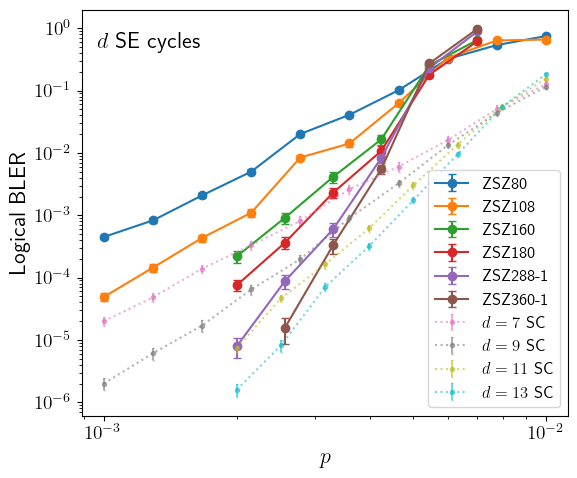

In [99]:
p_lists = []
p_lists.append(np.load('Data/p_list_ZSZ80.npy'))
p_lists.append(np.load('Data/p_list_ZSZ108.npy'))
p_lists.append(np.load('Data/p_list_ZSZ160.npy'))
p_lists.append(np.load('Data/p_list_ZSZ180.npy'))
p_lists.append(np.load('Data/p_list_ZSZ288.npy'))
p_lists.append(np.load('Data/p_list_ZSZ360.npy'))

p_lists_SC = []
p_lists_SC.append(np.load('Data/p_list_SC_d=7.npy'))
p_lists_SC.append(np.load('Data/p_list_SC_d=9.npy'))
p_lists_SC.append(np.load('Data/p_list_SC_d=11.npy'))
p_lists_SC.append(np.load('Data/p_list_SC_d=13.npy'))

ZSZdata = []
ZSZdata.append(np.load('Data/ZSZ80_LERs_w=10.npy'))
ZSZdata.append(np.load('Data/ZSZ108_LERs_w=12.npy'))
ZSZdata.append(np.load('Data/ZSZ160_LERs_w=16.npy'))
ZSZdata.append(np.load('Data/ZSZ180_LERs_w=18.npy'))
ZSZdata.append(np.load('Data/ZSZ288_LERs_w=16.npy'))
ZSZdata.append(np.load('Data/ZSZ360_LERs_w=20.npy'))

SCdata = []
SCdata.append(np.load('Data/SC_d=7.npy'))
SCdata.append(np.load('Data/SC_d=9.npy'))
SCdata.append(np.load('Data/SC_d=11.npy'))
SCdata.append(np.load('Data/SC_d=13.npy'))

y = []
y_errs = []
for i in range(len(ZSZdata)):
    p = ZSZdata[i][:,0]/ZSZdata[i][:,1]
    y.append(p)
    y_errs.append(np.sqrt(p*(1-p)/ZSZdata[i][:,1]))

z = []
z_errs = []
for i in range(len(SCdata)):
    p = SCdata[i][:,0]/SCdata[i][:,1]
    z.append(p)
    z_errs.append(np.sqrt(p*(1-p)/SCdata[i][:,1]))

labels=['ZSZ80', 'ZSZ108', 'ZSZ160', 'ZSZ180', 'ZSZ288-1', 'ZSZ360-1']
labels_SC=['$d=7$ SC', '$d=9$ SC', '$d=11$ SC', '$d=13$ SC']
plt.figure(figsize=[6,5])
for i in range(len(y)):
    plt.errorbar(p_lists[i], y[i], yerr=y_errs[i], fmt='o-', capsize=3, label=labels[i])
for i in range(len(z)):
    plt.errorbar(p_lists_SC[i], z[i], yerr=z_errs[i], fmt='.:', capsize=1, alpha=0.6, label=labels_SC[i])
plt.xlabel('$p$', fontsize=16)
plt.ylabel(r'Logical BLER', fontsize=16)
# plt.title('$d$ rounds, $p_1=p/10$, $p_2=p_{\mathrm{spam}}=p$')
plt.yscale('log')
plt.xscale('log')
plt.figtext(0.18, 0.88, '$d$ SE cycles', size=16)
plt.legend(fontsize=12)
plt.tight_layout()
# plt.savefig('Plots/ZSZ_vs_SC_BLER.pdf')

# Surface code

In [70]:
res = 6
p_min = 3E-3
p_max = 1E-2
p_list = np.logspace(np.log10(p_min), np.log10(p_max), res)
print(p_list)

[0.003      0.00381678 0.00485593 0.00617801 0.00786003 0.01      ]


In [75]:
d = 19
surface_code = hgp(h1=rep_code(d),h2=rep_code(d))
cycles = d
iters = np.logspace(7, 2, res, dtype=int)
circuit_seed = 0

THREADS = 10    # Number of parallel threads
pool = Pool(processes=THREADS)

for r in range(0,res):
    print('Progress: {} / {}     '.format(r+1,res), end='\r')
    
    params = (surface_code, p_list[r]/10, p_list[r], p_list[r], iters[r]//THREADS, cycles, circuit_seed)
    args = [params for j in range(THREADS)]
    if __name__ ==  '__main__':
        failures = pool.starmap(MWPM_threshold.get_MWPM_failures, args)
        LERs = [np.sum(failures), iters[r]//THREADS*THREADS]

    LERs_saved = np.load('Data/SC_d={}.npy'.format(d))
    LERs_saved[r] += LERs
    np.save('Data/SC_d={}.npy'.format(d), LERs_saved)
    
pool.close()

Progress: 6 / 6     

In [71]:
np.save('Data/p_list_SC_d=19', p_list)

In [73]:
np.save('Data/SC_d={}'.format(19), np.zeros([res,2],dtype=int))

In [76]:
print(np.load('Data/SC_d={}.npy'.format(19)))

[[      10 10000000]
 [      14  1000000]
 [      17   100000]
 [      40    10000]
 [      50     1000]
 [      28      100]]
